#  Analysing the Intraday Price Drift of European Stocks, Conditioned on their ADR Prices

I want to investigae the lead-lag relationship between American Depositary Receipts (ADRs) and their underlying European stocks. I will look at the ADR intraday returns (note the American Market Opens after the European morning session) and condition these returns in 3 ways: positive, negative and neutral. I will then look at the European specific cumulative returns in the morning session of the next day.

In [130]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, shapiro
from matplotlib import ticker
from datetime import time, datetime,timedelta

ADR's taken from S&P Developed Markets ADR Index, mixture of European stocks in UK, France, Germany, Denmark and Switzerland. In order to calculate specific returns we need the relevant markets.

In [131]:
ADR_tickers=["NVO","ASML","SHEL","AZN","NVS","TTE","HSBC","SAP","UL","BP"]
EUR_tickers=["NOVO-B.CO","AML.L","SHEL.L","AZN.L","NOVN.SW","TTE.PA","HSBA.L","SAP.DE","ULVR.L","BP.L"]

EUR_ticker_country={"NOVO-B.CO":"DEN",
                    "AML.L":"LON",
                    "SHEL.L":"LON",
                    "AZN.L":"LON",
                    "NOVN.SW":"SWI",
                    "TTE.PA":"FRA",
                    "HSBA.L":"LON",
                    "SAP.DE":"DEU",
                    "ULVR.L":"LON",
                    "BP.L":"LON"}

country_exchange={"LON":"^FTSE",
                  "DEN":"^OMXCGI",
                  "SWI":"^SSMI",
                  "FRA":"^FCHI",
                  "DEU":"^GDAXI"}

ticker_dict={key:value for key,value in zip(ADR_tickers,EUR_tickers)}

In [132]:
today=datetime.now().date()
today_day=today-timedelta(days=1)
two_years_ago=today-timedelta(days=(2*365-1))
START_DATE=two_years_ago
END_DATE=today_day
INTERVAL='1h'
MORNING_OPEN= "08:00:00"
MORNING_CLOSE= "12:00:00"
DAY_SHIFT=1

In [133]:
def get_intraday_returns(ticker,country=None,start_date=START_DATE,end_date=END_DATE,day_shift=None):
    
    data = yf.download(ticker, start=START_DATE, end=END_DATE)
    intraday_returns = (data['Close'] - data['Open']) / data['Open']
    intraday_returns = pd.DataFrame(intraday_returns).shift(day_shift).dropna()
    
    return intraday_returns

In [134]:
SP_data=get_intraday_returns("SPY",day_shift=DAY_SHIFT)

[*********************100%%**********************]  1 of 1 completed


Creating a dictionary to store the residual intraday returns of the ADR's with the S&P taken as the relevant market

In [135]:
adr_data_dict={}
for ticker in ticker_dict:
    cur_data=pd.DataFrame()
    cur_data["returns"]=get_intraday_returns(ticker,day_shift=DAY_SHIFT)-SP_data
    cur_data["Date"]=cur_data.index.date
    adr_data_dict[ticker]=cur_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In order to condition the data into positive, negative and neutral I first visualise the data and see if a normal distribution can describe it well. We see that for some tickers, the data is modelled well by a normal distribution (using the Shapiro-Wilk test to check). However not all the data is modelled well by a normal distribution.

In [136]:
def plot_resid(ax,resid_df,title_index):
    values=resid_df["returns"].values
    mean,std=norm.fit(values)
    ax.hist(values, bins=10, density=True, alpha=0.6, color='g')
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    ax.plot(x, p, 'k', linewidth=2)
    ax.set_title(ADR_tickers[i])
    ax.set_xlabel("Returns")
    ax.set_ylabel("Frequency")
    

Ticker: NVO, Statistic: 0.8402908444404602, p-value: 5.014004962294544e-22
Data does not look normally distributed
Ticker: ASML, Statistic: 0.9782226085662842, p-value: 8.464734833069087e-07
Data does not look normally distributed
Ticker: SHEL, Statistic: 0.8641549944877625, p-value: 2.008995848809986e-20
Data does not look normally distributed
Ticker: AZN, Statistic: 0.994780421257019, p-value: 0.08799496293067932
Data looks normally distributed
Ticker: NVS, Statistic: 0.9949286580085754, p-value: 0.0995759516954422
Data looks normally distributed
Ticker: TTE, Statistic: 0.9727697968482971, p-value: 5.0713733656948534e-08
Data does not look normally distributed
Ticker: HSBC, Statistic: 0.9921999573707581, p-value: 0.010201060213148594
Data does not look normally distributed
Ticker: SAP, Statistic: 0.9679394364356995, p-value: 5.430750515955651e-09
Data does not look normally distributed
Ticker: UL, Statistic: 0.9746352434158325, p-value: 1.277977332847513e-07
Data does not look normal

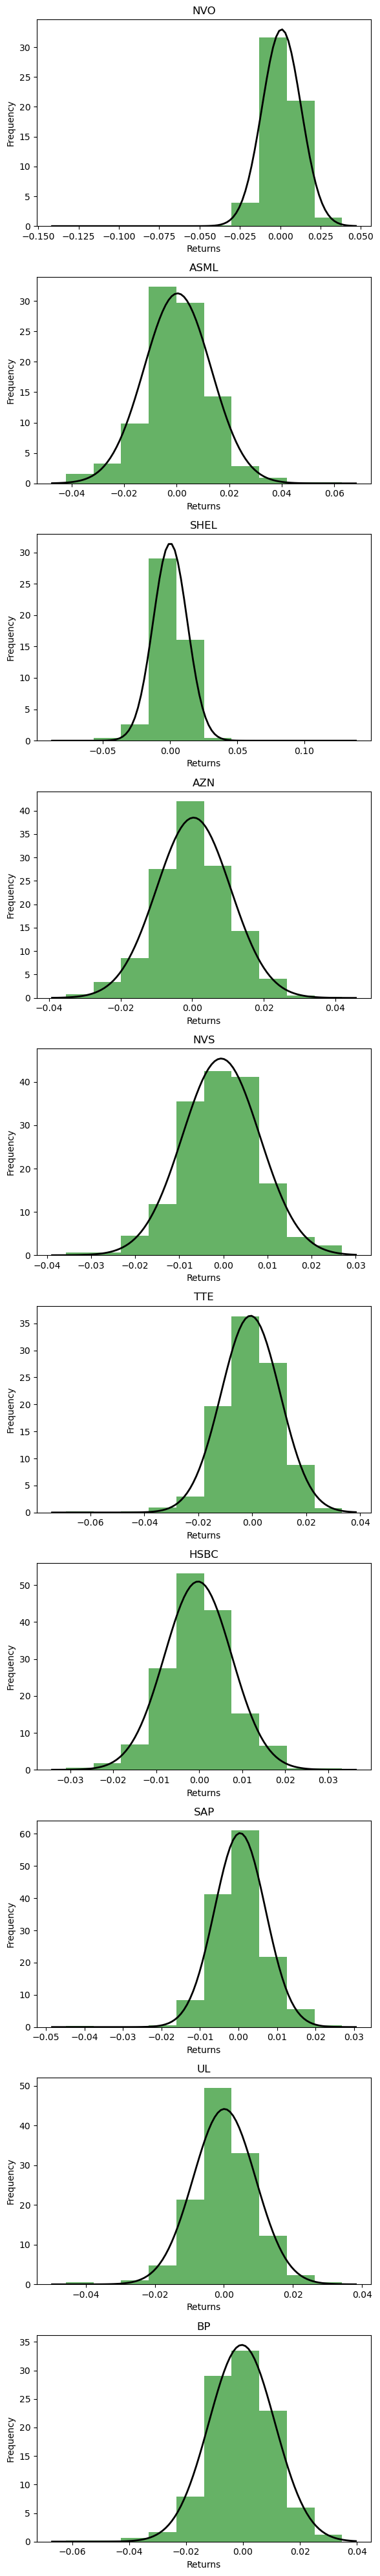

In [137]:
num_ticker=len(ticker_dict)
fig,axs=plt.subplots(nrows=num_ticker,ncols=1,figsize=(6,4*num_ticker))

i=0
for ticker in adr_data_dict:
    plot_resid(axs[i],adr_data_dict[ticker],i)
    i+=1
    stat, p_value = shapiro(adr_data_dict[ticker]["returns"])
    print(f'Ticker: {ticker}, Statistic: {stat}, p-value: {p_value}')

    if p_value > 0.05:
        print('Data looks normally distributed')
    else:
        print('Data does not look normally distributed')
    
plt.tight_layout()
plt.show()

I chose to condition the data based on percentiles. If the return was larger than the 66th percentile I took it to be positive, if it was smaller than the 33rd percentile I took it to be negative and anything inbetween was neutral. I could have had more specific conditions, for example making sure that the positive returns were larger than 0, but I found that this generic "filter" worked well.

In [138]:
def condition_data(data,lower_percentile=25,upper_percentile=75):
    #positive if >75th
    #negative if <25th
    #neutral if inbetween
    lower,upper=np.percentile(data["returns"].values,[lower_percentile,upper_percentile])
    

    positive=data[data["returns"]>upper].dropna()
    negative=data[data["returns"]<lower].dropna()
    neutral=data[(data["returns"]>=lower) & (data["returns"]<=upper)].dropna()
    
    return positive,negative,neutral

In [139]:
conditioned_data={}
for ticker in adr_data_dict:
    temp_cond_arr=condition_data(adr_data_dict[ticker])
    conditioned_data[ticker]=temp_cond_arr

European stock data is downloaded at hourly intervals and it is filtered such that only the data for the morning session remained. The returns are then made specific with their relevant markets.

In [140]:
def get_eur_market_returns(ticker,start_date=START_DATE,end_date=END_DATE,interval="1h"):
    data=yf.download(ticker,start_date,end_date,interval="1h")
    out_df=pd.DataFrame()
    out_df["Close"]=data["Close"]
    data=data.between_time(MORNING_OPEN,MORNING_CLOSE)
    
    return out_df

eur_market_dict={}
for country in country_exchange:
    eur_market_dict[country_exchange[country]]=get_eur_market_returns(country_exchange[country])


def get_eur_spec_returns(ticker,start_date=START_DATE,end_date=END_DATE,interval="1h"):
    data=yf.download(ticker,start_date,end_date,interval="1h")
    data=data.between_time(MORNING_OPEN,MORNING_CLOSE)
    out_df=pd.DataFrame()
    out_df["raw_returns"]=data["Close"]
    out_df["Date"]=data.index.date
    
    
    #out_df["raw_returns"]=out_df["raw_returns"]-FT_data["Close"]
    out_df["raw_returns"]=out_df["raw_returns"]-eur_market_dict[country_exchange[EUR_ticker_country[ticker]]]["Close"]

    
    
    return out_df.dropna()

eur_data_dict={}
for ticker in EUR_tickers:
    eur_data_dict[ticker]=get_eur_spec_returns(ticker)
    

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

I took the dates of the conditioned ADR data, which had been shifted back a day, such that when conditioning the European data, I was looking at the following morning session.

In [141]:
def condition_euro_data(data,cond_df_arr):
    
    positive_df,negative_df,neutral_df=cond_df_arr
    
    data=time_elapsed(data)
    eur_pos_df=data[data["Date"].isin(positive_df["Date"])]
    eur_neg_df=data[data["Date"].isin(negative_df["Date"])]
    eur_neu_df=data[data["Date"].isin(neutral_df["Date"])]
    
    eur_pos_df=cum_return(eur_pos_df)
    eur_neg_df=cum_return(eur_neg_df)
    eur_neu_df=cum_return(eur_neu_df)
    
    return eur_pos_df,eur_neg_df,eur_neu_df

def condition_next_euro_data(data,cond_df_arr):
    
    positive_df,negative_df,neutral_df=cond_df_arr
    
    data=time_elapsed(data)
    eur_pos_df=data[data["Date"].isin(positive_df["Date"])]
    eur_neg_df=data[data["Date"].isin(negative_df["Date"])]
    eur_neu_df=data[data["Date"].isin(neutral_df["Date"])]
    
    eur_pos_df=cum_return(eur_pos_df)
    eur_neg_df=cum_return(eur_neg_df)
    eur_neu_df=cum_return(eur_neu_df)
    
    return eur_pos_df,eur_neg_df,eur_neu_df

def time_elapsed(data):
    
    subtract_time=time(8,0)
    out_df=data.copy()
    out_df["time"]=data.index.time
    out_df["elapsed"]=out_df["time"].apply(lambda x: datetime.combine(datetime.today(), x) - datetime.combine(datetime.today(), subtract_time)).dt.total_seconds() / 3600
        
    return out_df

def cum_return(data):
    
    times=data["elapsed"]
    #data=data.groupby('Date',as_index=False)['raw_returns'].pct_change().add(1).cumprod()-1
    data=data.groupby('Date')['raw_returns'].pct_change()+1
    data=data.groupby(data.index.date).cumprod()
    data=pd.DataFrame(data)
    data["elapsed"]=times
    data.columns=["cum_returns","elapsed"]
   
    return data.dropna()



In [142]:
positive_dict={}
negative_dict={}
neutral_dict={}

for adr,eur in zip(conditioned_data,eur_data_dict):
    positive_dict[adr],negative_dict[adr],neutral_dict[adr]=condition_euro_data(eur_data_dict[eur],conditioned_data[adr])
    
positive_df=pd.concat(positive_dict.values(),ignore_index=True)
negative_df=pd.concat(negative_dict.values(),ignore_index=True)
neutral_df=pd.concat(neutral_dict.values(),ignore_index=True)

In [143]:
def plot_expcum_time(data,title):
    average=data.groupby("elapsed")["cum_returns"].mean().reset_index()
    plt.plot(average['elapsed'], average['cum_returns'], marker='o',linestyle="")
    plt.xlabel('Elapsed Time Since Market Open (hours)')
    plt.xticks([1,2,3,4])
    plt.ylabel('Cumulative Returns')
    plt.title(title+' Cumulative Returns Over Time')
    plt.show()

In [144]:
def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline"                
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90
            )
            
row_headers=ADR_tickers
col_headers=["Positive","Negative","Neutral"]

In [145]:
def subplot_resid(ax,data,title):
    average=data.groupby("elapsed")["cum_returns"].mean().reset_index()
    ax.plot(average['elapsed'].values, average['cum_returns'].values, marker='o',linestyle="")
    ax.set_xlabel('Elapsed Time Since Market Open (hours)')
    ax.set_xticks([1,2,3,4])
    ax.set_ylabel('Cumulative Returns')

Here I plotted the positive, negative and neutral cumulative returns for each ticker. In general we see that positive returns in ADR's lead to decreasing returns in the European morning session. On the contrary, negative returns in ADR's lead to a generally increasing positive return in the European morning session. Neutral returns had both increasing and decreasing returns which varied stock to stock.

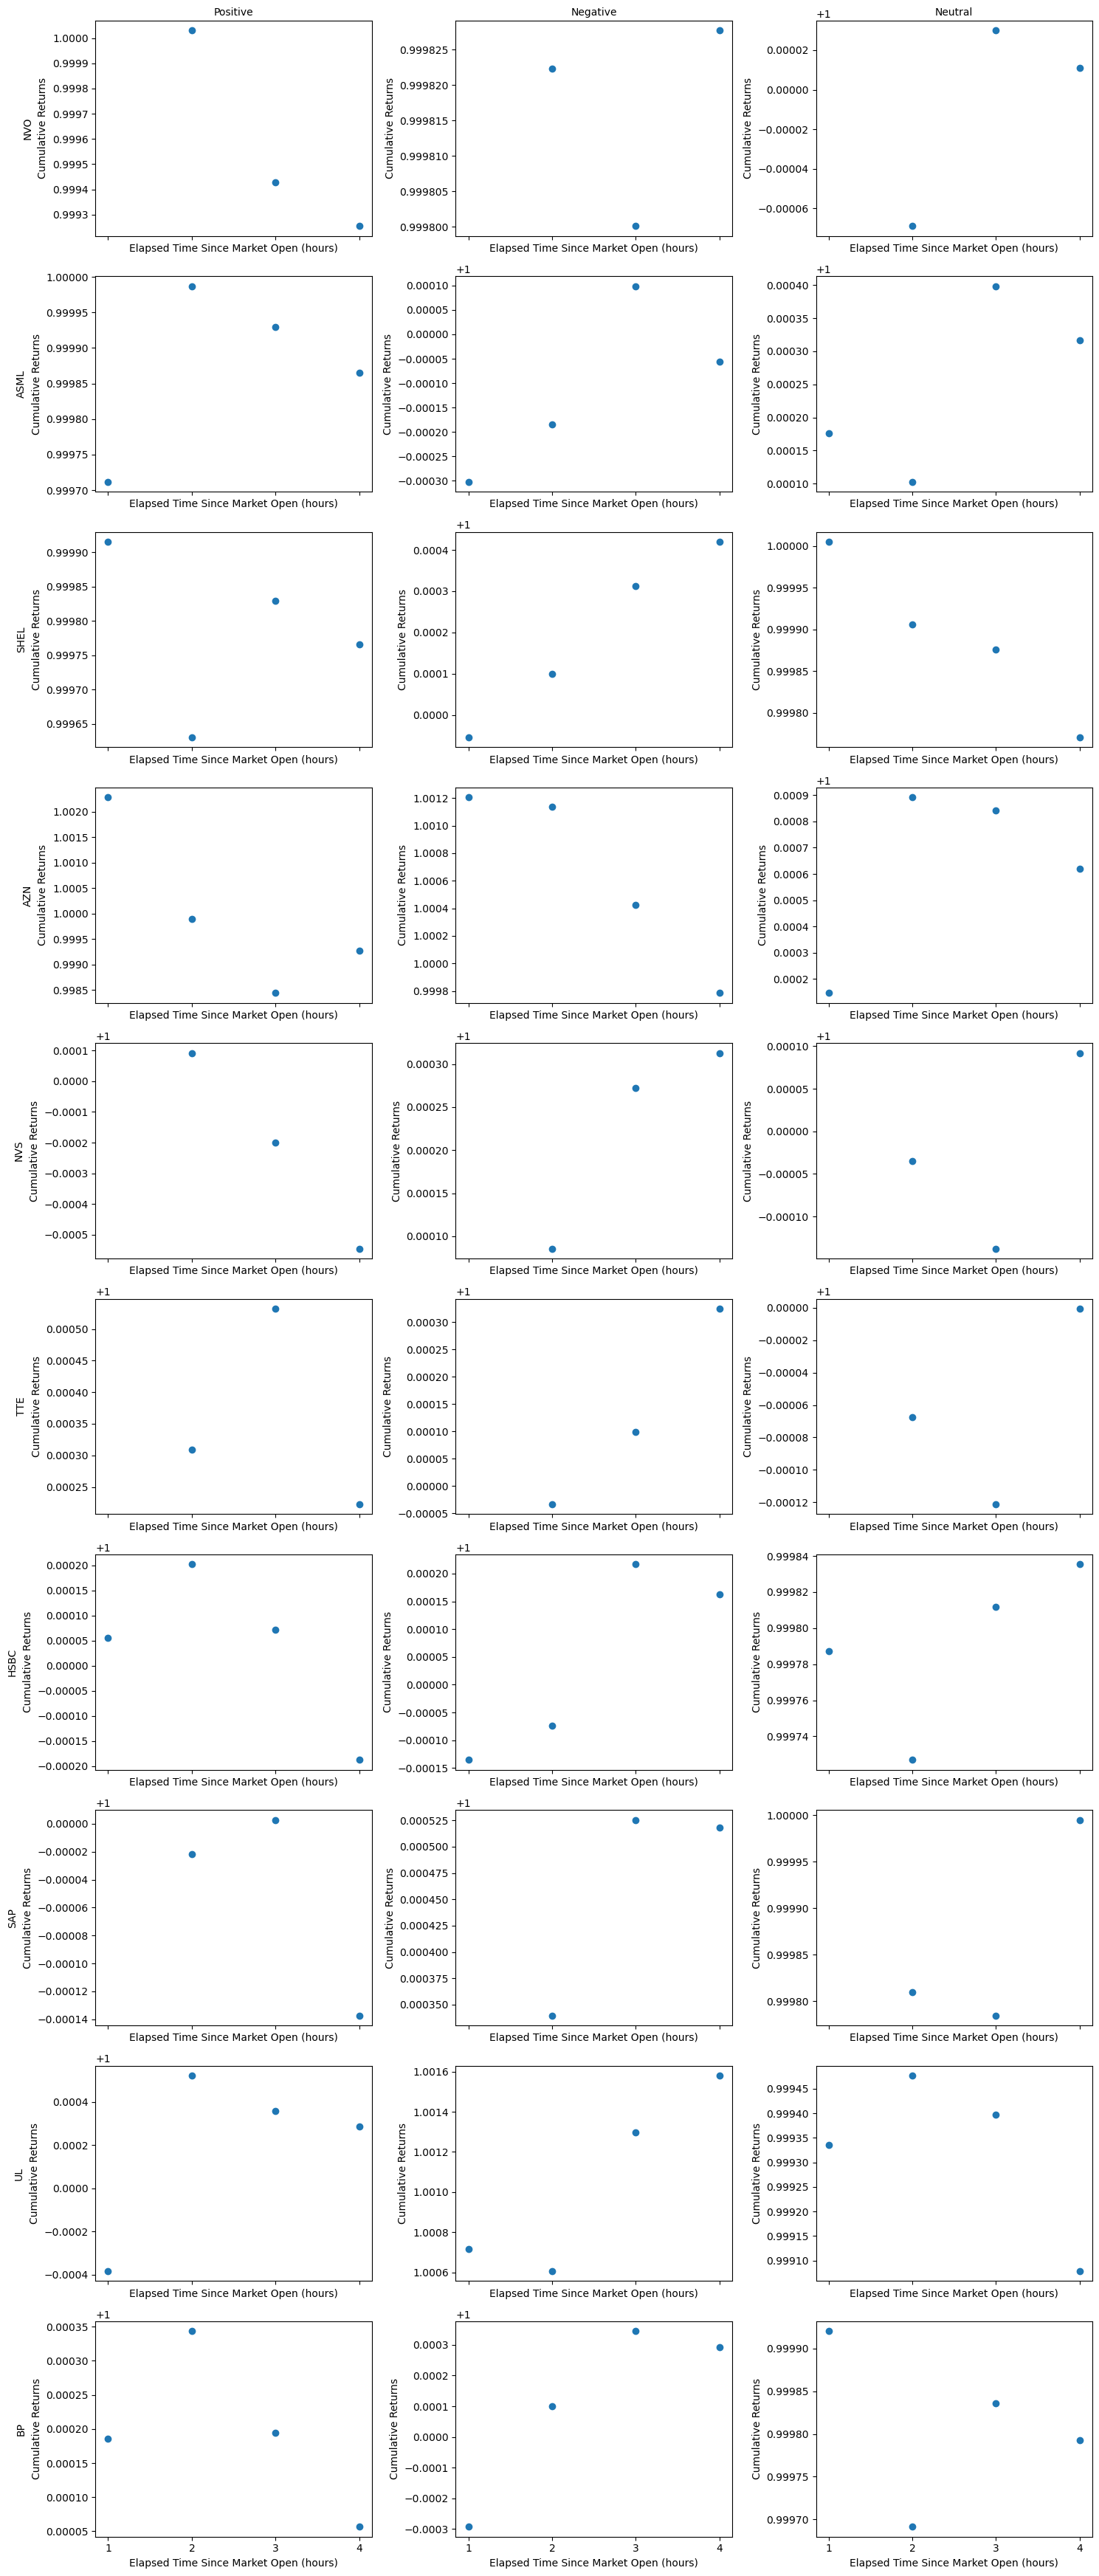

In [146]:
n=len(ADR_tickers)
fig,axs=plt.subplots(nrows=n,ncols=3,figsize=(15,3.5*n),sharex=True)
axs=axs.flatten()

i=0
for ticker in ADR_tickers:
    for cond,t in zip([positive_dict,negative_dict,neutral_dict],["Positive","Negative","Neutral"]):
        subplot_resid(axs[i],cond[ticker],t)
        i+=1
    
add_headers(fig, col_headers=col_headers, row_headers=row_headers)
plt.tight_layout()
plt.show()

Here we average the cumulative return based on the elpased time since market has open. We clearly see that for positive conditioned data in America, the corresponding next day European cumulative returns decrease with elapsed time and even go below 1-i.e. a decrease from the initial value. Alternatively the negatively conditioned American data yields cumulative returns that increase as elapsed time since market open increases, with a peak 3 hours after market open. Neutral conditioned data also shows an increase in cumulative returns but all values were below 1.

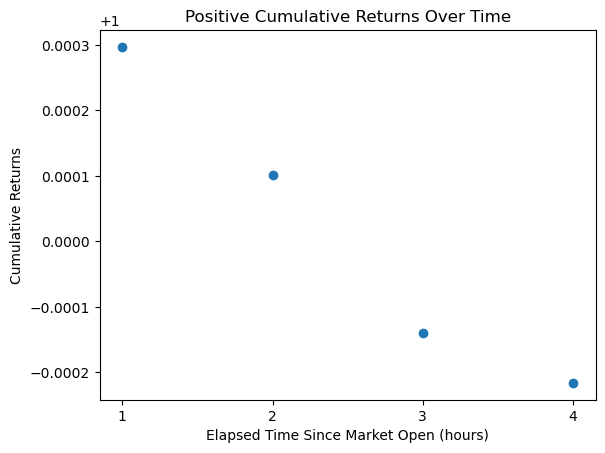

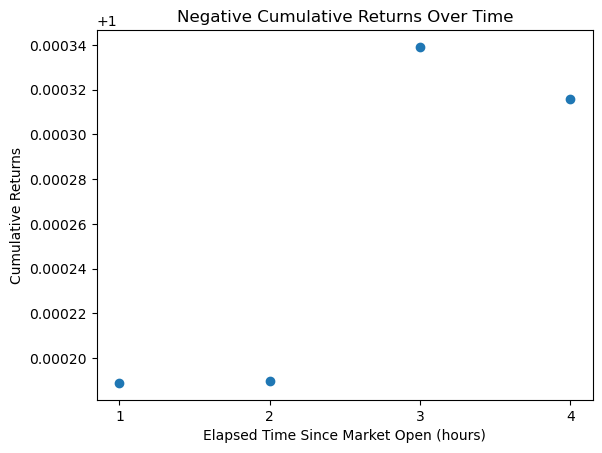

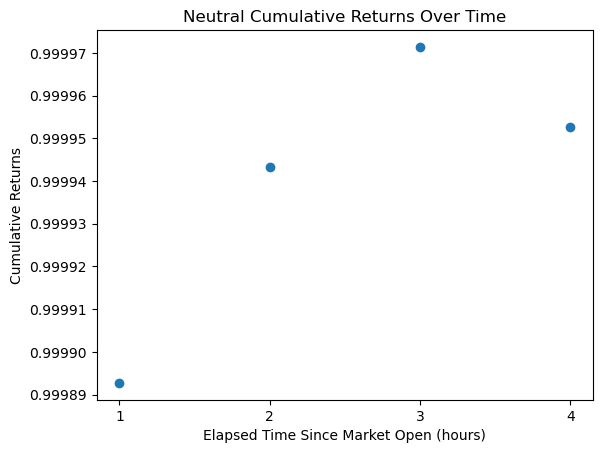

In [147]:
for i,t in zip([positive_df,negative_df,neutral_df],["Positive","Negative","Neutral"]):
    plot_expcum_time(i,t)